<a href="https://colab.research.google.com/github/Jun-Imamura/Introduction-To-Deep-Learning-Week3/blob/main/notebookcbb9ba8759.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the Project
In this assignment, Kaggle competition called [Histopathologic Cancer Detection](https://www.kaggle.com/c/histopathologic-cancer-detection/overview) is used to try CNN learned in the week3 lecture.

***
## Problem Description
In this competition, large number of small pathology images are given. The image size is 96x96 and named with image id. The `train_labels.csv` provides boolean ground truth for each image ids.

Ground truth "positive" label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Outer region is not taken into account when label is assigned. We are required to classify positive/negative against given images.

Dataset size is about 7GB. We may need to consider subsampling of the data to avoid too much computation time required to run learning phase.

***
### Import Libraries

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import gc

from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Flatten, Dense, Dropout, MaxPooling2D

from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras.optimizers import Adam, RMSprop
from keras.metrics import AUC
from keras.applications import VGG16

from keras.preprocessing.image import ImageDataGenerator
from keras import Model

In [2]:
! pip install -q kaggle
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [3]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.31G/6.31G [04:54<00:00, 23.8MB/s]
100% 6.31G/6.31G [04:54<00:00, 23.0MB/s]


In [4]:
!ls .

histopathologic-cancer-detection.zip  sample_data


In [5]:
!unzip histopathologic-cancer-detection.zip > /dev/null 2>&1

#### Set Paths for the Dataset

In [6]:
!ls .

histopathologic-cancer-detection.zip  sample_submission.csv  train
sample_data			      test		     train_labels.csv


In [7]:
label_csv_path = "./train_labels.csv"
sample_submission_path = "./sample_submission.csv"
train_img_dir_path = "./train/"
test_img_dir_path = "./test/"

## EDA
The number of data is as follows. Data size is about 2 hundred thousand.

In [8]:
print("training data size: ", len(os.listdir(train_img_dir_path)))
print("test data size: ", len(os.listdir(test_img_dir_path)))

training data size:  220025
test data size:  57458


Data label balance is not bad. If we observe strong biased balance, we need to take it into account.

In [9]:
label_df = pd.read_csv(label_csv_path)
label_df["label"].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

As the label is associated with id and file path contains id information, we can create combined dataframe by merging them

In [10]:
df = pd.DataFrame({"path": glob.glob(os.path.join(train_img_dir_path, "*.tif"))})
df["id"] = df["path"].map(lambda x: os.path.splitext(os.path.basename(x))[0])
df = df.merge(label_df, on="id")
df.head()

,path,id,label
0,./train/73298dc242f02f20ef48fcc183ab451a535ca5...,73298dc242f02f20ef48fcc183ab451a535ca51d,0
1,./train/382ccfe0cf677d8dbe57f737425e405f394845...,382ccfe0cf677d8dbe57f737425e405f394845c8,0
2,./train/239a16f73d0bbe2bdfce07dd982e4f9a4a3345...,239a16f73d0bbe2bdfce07dd982e4f9a4a334596,0
3,./train/7b65bc2b474070d07f337988009730a4778aa0...,7b65bc2b474070d07f337988009730a4778aa035,1
4,./train/755c8163c15a3859215b456cf1813c10dbc335...,755c8163c15a3859215b456cf1813c10dbc33590,1


### Visualize Example Image

In [11]:
n_image = 5

random_positive_indces =  np.random.choice(df[df["label"] == 1].index, size=5)
random_negative_indces =  np.random.choice(df[df["label"] == 0].index, size=5)

In [12]:
def visualize_images(df, indces):
    fig, ax = plt.subplots(1, n_image, figsize=(20, 4))

    for i, idx in enumerate(indces):
        path = os.path.join(train_img_dir_path, df.iloc[idx]['id']) + ".tif"
        print(i, " \t id:" , idx, "\t path:", path)
        bgr_img = cv2.imread(path)
        b,g,r = cv2.split(bgr_img)
        rgb_img = cv2.merge([r,g,b])

        ax[i].imshow(rgb_img)

    ax[0].set_ylabel('samples', size='large')
    plt.show()

### Positive Example

0  	 id: 166407 	 path: ./train/a02139477b29928806ceaeb63b0889e2edd29964.tif
1  	 id: 17050 	 path: ./train/8d86edbda7728da28fa817a397e595a3413288b7.tif
2  	 id: 77871 	 path: ./train/6e37631e5e8e351cbbcd4aed3eb5bd35344969c7.tif
3  	 id: 61653 	 path: ./train/3dc4bc29942bf8dfb60b71db4e76f80aa431b49f.tif
4  	 id: 154532 	 path: ./train/ad1554a15fd28a8d79b080cb55b8be8b721971cf.tif


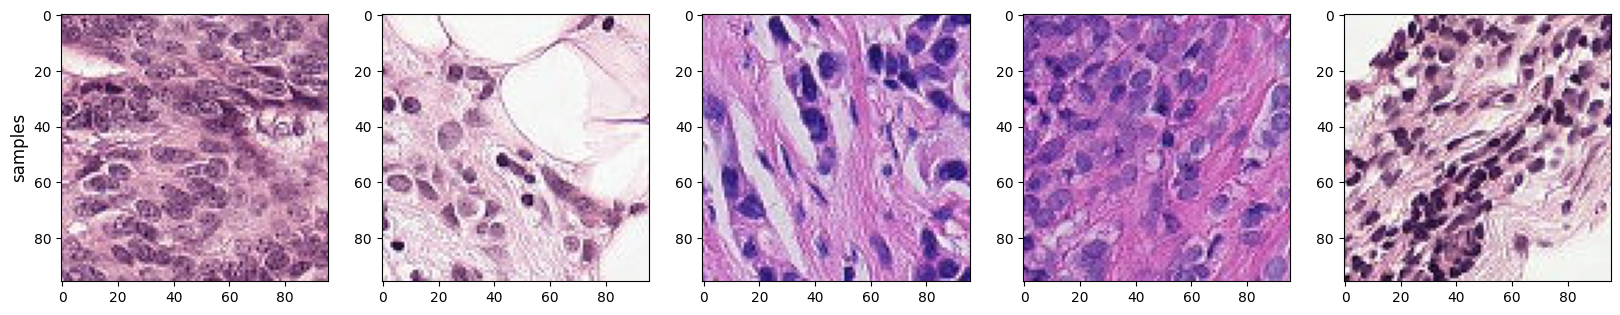

In [13]:
visualize_images(df, random_positive_indces)

### Negative Example

0  	 id: 182782 	 path: ./train/02b8fb2fcef7f366527c0c358907a9adb457e59a.tif
1  	 id: 136657 	 path: ./train/703169eaf87675060395484d4db5fb5cece64a42.tif
2  	 id: 91553 	 path: ./train/e49e813466172c2fb8fa356c8dc46f1c36fafcdf.tif
3  	 id: 73562 	 path: ./train/e8a10e753564bb30ceecb0c6638b878e1822024b.tif
4  	 id: 68957 	 path: ./train/a55ee917a9b2508a865dcec4cd1cb84d86239057.tif


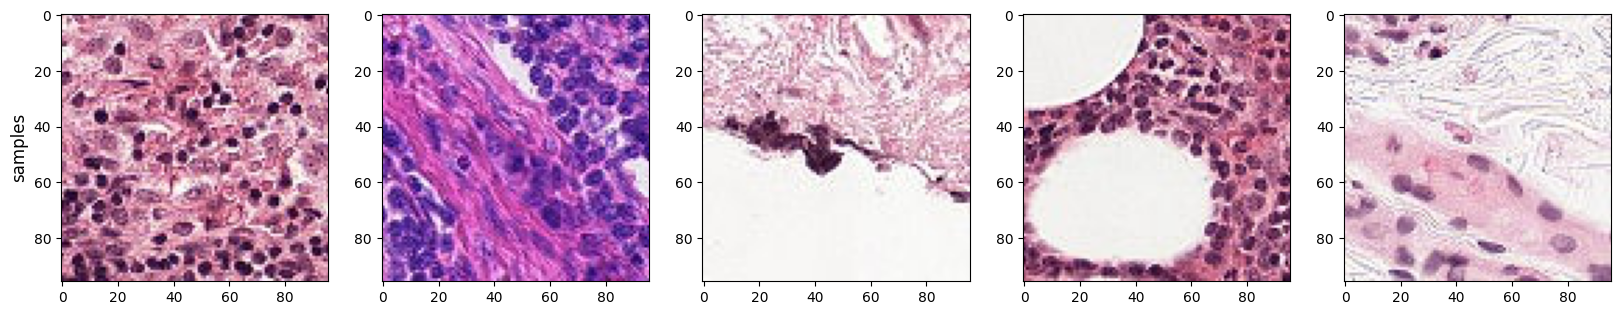

In [14]:
visualize_images(df, random_negative_indces)

In [15]:
# Randomly select n indices from the dataframe
n = 3000
random_indices =  np.random.choice(df.shape[0], size=n, replace=False)

# Allocate a numpy array
X = np.zeros([n, 96, 96, 3], dtype=np.uint8)
y = np.squeeze(df['label'].values)[random_indices]

# read images
for i, idx in enumerate(random_indices):
    X[i] = cv2.imread(df.loc[idx, 'path'])

In [16]:
# seperate positive and negaive sample and get means
pos_samples = X[y == 1]
neg_samples = X[y == 0]

n_smaller= min(len(pos_samples), len(neg_samples))
if len(pos_samples) > len(neg_samples):
    pos_samples = pos_samples[0: n_smaller]
else:
    neg_samples = neg_samples[0: n_smaller]

# means brightness of positive and negative samples
pos_sample_avgs=np.mean(pos_samples, axis=(1,2,3))
neg_sample_avgs=np.mean(neg_samples, axis=(1,2,3))
pos_sample_mins=np.min(pos_samples, axis=(1,2,3))
neg_sample_mins=np.min(neg_samples, axis=(1,2,3))
pos_sample_maxs=np.max(pos_samples, axis=(1,2,3))
neg_sample_maxs=np.max(neg_samples, axis=(1,2,3))

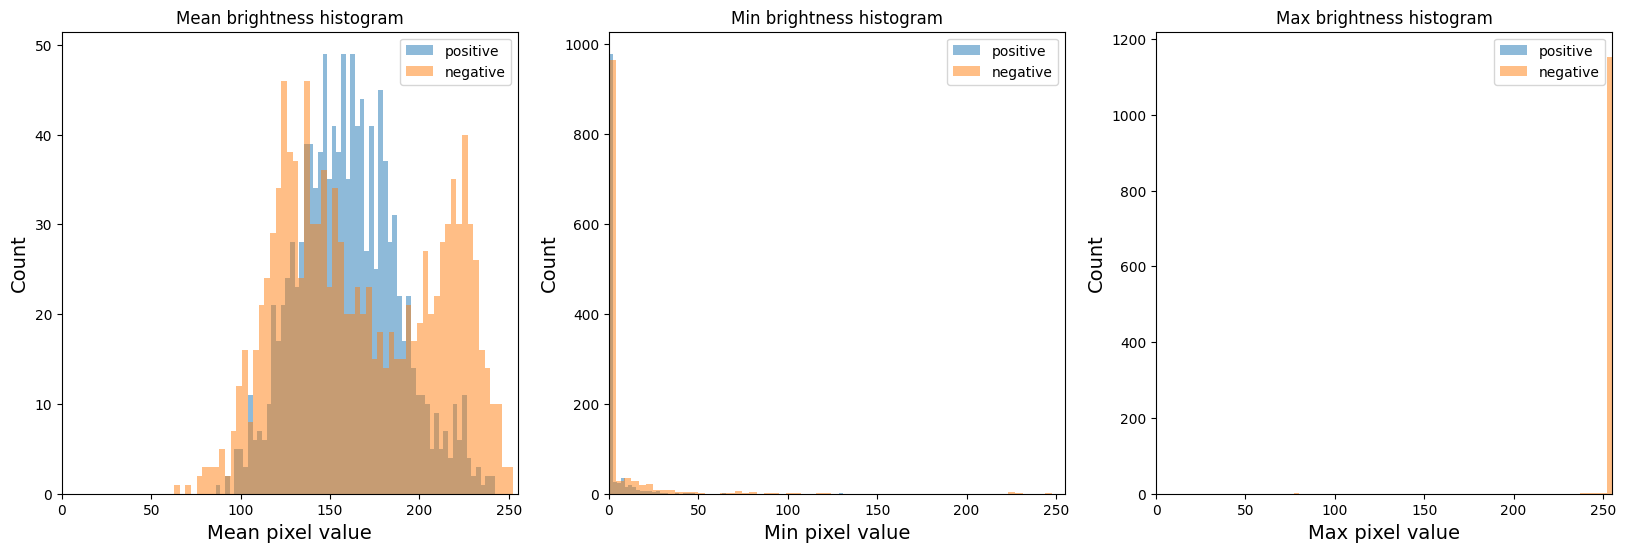

In [17]:
# Plot mean,min,max brightness histograms for positive and negative samples
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].hist(pos_sample_avgs, bins= 60, alpha=0.5, label="positive")
axs[0].hist(neg_sample_avgs, bins= 60, alpha=0.5, label="negative")
axs[0].set_title("Mean brightness histogram")
axs[0].set_xlabel("Mean pixel value", size=14)
axs[0].set_ylabel("Count", size=14)
axs[0].set_xlim([0, 255])
axs[0].legend(loc='upper right')

axs[1].hist(pos_sample_mins, bins= 60, alpha=0.5, label="positive")
axs[1].hist(neg_sample_mins, bins= 60, alpha=0.5, label="negative")
axs[1].set_title("Min brightness histogram")
axs[1].set_xlabel("Min pixel value", size=14)
axs[1].set_ylabel("Count", size=14)
axs[1].set_xlim([0, 255])
axs[1].legend(loc='upper right')

axs[2].hist(pos_sample_maxs, bins= 60, alpha=0.5, label="positive")
axs[2].hist(neg_sample_maxs, bins= 60, alpha=0.5, label="negative")
axs[2].set_title("Max brightness histogram")
axs[2].set_xlabel("Max pixel value", size=14)
axs[2].set_ylabel("Count", size=14)
axs[2].set_xlim([0, 255])
axs[2].legend(loc='upper right')


***
## Create DNN Model

In [18]:
# train test split
df_train, df_valid = train_test_split(df, test_size=0.10, random_state=100)
df_train.reset_index(inplace = True)
df_valid.reset_index(inplace = True)
# df.set_index('id', inplace=True)

In [19]:
# Collect garbage to free up memory
del pos_samples
del neg_samples
del pos_sample_avgs
del neg_sample_avgs
del pos_sample_mins
del neg_sample_mins
del pos_sample_maxs
del neg_sample_maxs
del df
gc.collect()

14883

In [20]:
print(df_train.shape, df_valid.shape)
print(df_train)

(198022, 4) (22003, 4)
         index                                               path  \
0        31636  ./train/f07bd0718ca604a1658bf506bff39ef3f09b54...   
1        90295  ./train/b5100ce961f77a0a20287d2773f6b95ce564e6...   
2        50436  ./train/95f056e90645c0ae703f77da80e1964a88be60...   
3       205697  ./train/1bb7ce584b80eea83e54874dcf6bb0c3d56e9b...   
4       163119  ./train/2744dcd2b9c4ea81f1bd1f9c3b7fe60769afd8...   
...        ...                                                ...   
198017   65615  ./train/00c5d1cbabdce3cec9884a8b75aaf45a2928fb...   
198018   77655  ./train/2d8f19437068aae21f8f60ff13697213cbf113...   
198019  210755  ./train/3a15e4588ced68a47ad32b40cb13d6c7e72219...   
198020   56088  ./train/cfac706320a44ed7761c12f85901414bbb7ad7...   
198021   38408  ./train/b91bec332e77530c52978a6c0ae3bb887b7def...   

                                              id  label  
0       f07bd0718ca604a1658bf506bff39ef3f09b5476      0  
1       b5100ce961f77a0a20287d27

#### Quick fix
As the dataset is too large, it would be better to store as serialized data so that we don't need to open up images each time we do re-run.

In [21]:
# Allocate a numpy array
train_X = np.zeros([df_train.shape[0], 96, 96, 3], dtype=np.uint8)
valid_X = np.zeros([df_valid.shape[0], 96, 96, 3], dtype=np.uint8)

# read images
for i, row in df_train.iterrows():
    train_X[i] = cv2.imread(row['path'])
for i, row in df_valid.iterrows():
    valid_X[i] = cv2.imread(row['path'])

np.save("train_X.npy", train_X)
np.save("valid_X.npy", valid_X)

In [22]:
train_X = np.load("train_X.npy")
valid_X = np.load("valid_X.npy")
train_y = df_train["label"]
valid_y = df_valid["label"]

In [23]:
# Build model 1
# Note for model 1 to model 3, I used copied numpy data. I later found this method consumes too much memory.
mymodel_1 = tf.keras.models.Sequential([
   Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
   Conv2D(32, (3, 3), activation='relu'),
   MaxPooling2D((2, 2)),
   Conv2D(64, (3, 3), activation='relu'),
   Conv2D(64, (3, 3), activation='relu'),
   MaxPooling2D((2, 2)),
   Conv2D(64, (1, 1), activation='relu'),
   Flatten(),
   Dense(64, activation='relu'),
   Dense(64, activation='relu'),
   Dense(1, activation='sigmoid')
])

# Model summary
mymodel_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 42, 42, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 21, 21, 64)        0         
 g2D)                                                   

In [24]:
# compile model 1

# Define the learning rate schedule (exponential decay)
initial_learning_rate = 0.001
decay_steps = 1000 # total steps = (training size/batchsize) * number of epochs, 200,000/64*3= around 10000
decay_rate = 0.9
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps, decay_rate, staircase=True)

mymodel_1.compile(
    optimizer=Adam(learning_rate= lr_schedule),
    loss='binary_crossentropy',
    metrics=[AUC()]
)

In [25]:
# # Fit model 1
# datagen = ImageDataGenerator(rescale=1.0 / 255.0)
# train_generator = datagen.flow(train_X, train_y, batch_size=64)
# val_generator = datagen.flow(valid_X, valid_y, batch_size=64)
# mymodel_1.fit(train_generator, validation_data=val_generator, epochs=10, batch_size=64, verbose=2)

In [26]:
mymodel1_history_auc=     [0.9000, 0.9528, 0.9703, 0.9809, 0.9884, 0.9933, 0.9961, 0.9977]
mymodel1_history_auc_val= [0.9416, 0.9622, 0.9702, 0.9724, 0.9693, 0.9705, 0.9674, 0.9636]

mymodel1_history_loss=         [0.3893, 0.2691, 0.2121, 0.1692, 0.1310, 0.0982, 0.0723, 0.0522]
mymodel1_history_loss_val=     [0.3036, 0.2483, 0.2153, 0.2046, 0.2254, 0.2318, 0.2643, 0.3013]

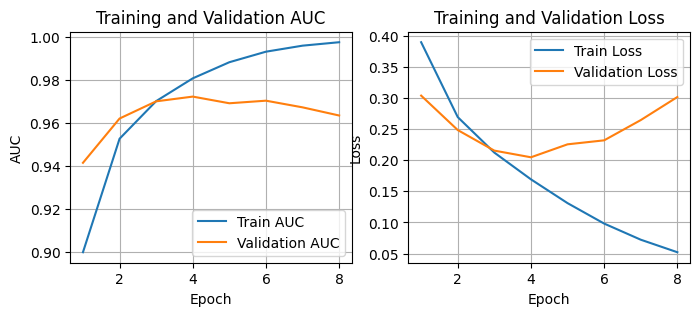

In [36]:
# history = mymodel_1.fit(X_train/255., y_train, validation_data=(X_val/255., y_val), epochs=5, batch_size=64, verbose=2)

# Plot training and validation AUC
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
# plt.plot(history.history['auc'], label='Train AUC')
# plt.plot(history.history['val_auc'], label='Validation AUC')
plt.plot(range(1, 9),mymodel1_history_auc, label='Train AUC')
plt.plot(range(1, 9),mymodel1_history_auc_val, label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(range(1, 9),mymodel1_history_loss, label='Train Loss')
plt.plot(range(1, 9),mymodel1_history_loss_val, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [28]:
# Collect garbage to free up memory
del mymodel_1

gc.collect()

7075

In [29]:
 # Load the DenseNet201
densenet_model = VGG16(weights='imagenet',include_top = False, input_shape=(96, 96, 3))

# Freeze the weights of the layers.
for layer in densenet_model.layers:
    layer.trainable = False

# get the last_layer of inception we want to use
last_layer = densenet_model.get_layer('block3_pool')
print('last layer output shape: ', last_layer.output_shape)

base_model = Model(inputs=densenet_model.input, outputs=last_layer.output)
base_model.summary()

58889256/58889256 [==============================] - 4s 0us/step
last layer output shape:  (None, 12, 12, 256)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                

In [30]:
# Add layers to the model
mymodel_3 = Sequential([
    base_model,

    Conv2D(16, (3, 3), padding='same', activation='relu'), # keep the width and height
    BatchNormalization(),
    Conv2D(16, (1, 1),activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Flatten(),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

# Print the model summary
mymodel_3.build(input_shape=(None, 96, 96, 3))
mymodel_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 12, 12, 256)       1735488   
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 16)        36880     
                                                                 
 batch_normalization (Batch  (None, 12, 12, 16)        64        
 Normalization)                                                  
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 16)        272       
                                                                 
 batch_normalization_1 (Bat  (None, 12, 12, 16)        64        
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 12, 12, 16)       

In [31]:
#Define the learning rate schedule (exponential decay)
initial_learning_rate = 0.001
decay_steps = 1000
decay_rate = 0.9
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps, decay_rate, staircase=True)

# Compile the model
mymodel_3.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='binary_crossentropy',
    metrics=[AUC()]
)

In [32]:
BATCH_SIZE = 64
EPOCHS = 10

# data generator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip=True,
    horizontal_flip=True,
)

train_generator = datagen.flow(train_X, train_y, batch_size=BATCH_SIZE)

val_generator = datagen.flow(valid_X, valid_y, batch_size=BATCH_SIZE)

steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)

# Fit model 3
history_3 = mymodel_3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1
)

Epoch 1/10
3095/3095 [==============================] - 488s 155ms/step - loss: 0.3178 - auc_1: 0.9329 - val_loss: 0.2699 - val_auc_1: 0.9535
Epoch 2/10
3095/3095 [==============================] - 478s 154ms/step - loss: 0.2553 - auc_1: 0.9563 - val_loss: 0.2615 - val_auc_1: 0.9564
Epoch 3/10
3095/3095 [==============================] - 484s 156ms/step - loss: 0.2400 - auc_1: 0.9613 - val_loss: 0.2167 - val_auc_1: 0.9679
Epoch 4/10
3095/3095 [==============================] - 481s 155ms/step - loss: 0.2307 - auc_1: 0.9641 - val_loss: 0.2319 - val_auc_1: 0.9686
Epoch 5/10
3095/3095 [==============================] - 480s 155ms/step - loss: 0.2246 - auc_1: 0.9659 - val_loss: 0.2105 - val_auc_1: 0.9698
Epoch 6/10
3095/3095 [==============================] - 480s 155ms/step - loss: 0.2208 - auc_1: 0.9670 - val_loss: 0.2015 - val_auc_1: 0.9722
Epoch 7/10
3095/3095 [==============================] - 481s 155ms/step - loss: 0.2169 - auc_1: 0.9681 - val_loss: 0.2027 - val_auc_1: 0.9719
Epoch 

In [33]:
mymodel3_history_auc=     [0.9329, 0.9563, 0.9613, 0.9641, 0.9659, 0.9670, 0.9681, 0.9685, 0.9696, 0.9695]
mymodel3_history_auc_val= [0.9535, 0.9564, 0.9679, 0.9686, 0.9698, 0.9722, 0.9719, 0.9729, 0.9744, 0.9732]

mymodel3_history_loss=         [0.3178, 0.2553, 0.2400, 0.2307, 0.2246, 0.2208, 0.2169, 0.2154, 0.2122, 0.2123]
mymodel3_history_loss_val=     [0.2699, 0.2615, 0.2167, 0.2319, 0.2105, 0.2015, 0.2027, 0.2002, 0.1934, 0.1958]

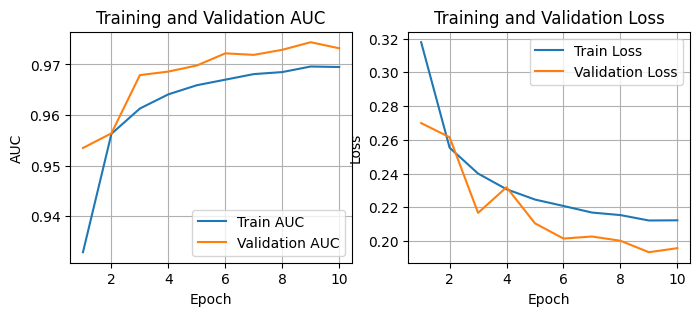

In [37]:
# Plot training and validation AUC
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.plot(range(1, 11),mymodel3_history_auc, label='Train AUC')
plt.plot(range(1, 11),mymodel3_history_auc_val, label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(range(1, 11),mymodel3_history_loss, label='Train Loss')
plt.plot(range(1, 11),mymodel3_history_loss_val, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.show()